# [Keras + Universal Sentence Encoder = Deep Meter] (https://www.dlology.com/blog/keras-meets-universal-sentence-encoder-transfer-learning-for-text-data/) 

This notebook creates an autoencoder using the Universal Sentence Encoder. The autoencoder output is CMUdict syllables. The dataset is that subset of Allison Parrish's Project Gutenberg poetry archive which happens to scan in iambic pentameter.

The notebook is based on Chengwei Zhang's example of wrapping the USE inside a larger tensorflow model saves to a Keras model (without save the USE itself in the TF model).

The Universal Sentence Encoder makes getting sentence level embeddings as easy as it has historically been to lookup the embeddings for individual words. The sentence embeddings can then be trivially used to compute sentence level meaning similarity as well as to enable better performance on downstream classification tasks using less supervised training data.

Since there are 10 one-hot values for 10 sets of 6k syllables, this is "multi-label classification"
Changes for multi-label classification:
sigmoid activation instead of softmax
binary_crossentropy

Text format is tab-separated, 2 columns: first text, second multi-level
array of syllables:

Output to one multi-label set of syllables. Used to train Human & Lizard levels how to output to syllables.

# Getting Started

This section sets up the environment for access to the Universal Sentence Encoder on TF Hub and provides examples of applying the encoder to words, sentences, and paragraphs.

In [1]:
# Install the latest Tensorflow version.
#!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
#!pip3 install --quiet tensorflow-hub
#%cd /content
!git clone https://github.com/LanceNorskog/deep_meter || true
%cd /content/deep_meter
!pip -q install -r requirements.txt
!git pull
# could not figure out how to read gzipped files as text!
!gunzip -qf blobs/*.gz || true
!gunzip -qf prepped_data/*.gz || true
# Need to scramble this with awk
AWK="awk '{print((rand()*1000000),\"\\t\",$0)}'"
CUT="cut -f2"
SPLIT="split -l20000 -a 5"
SHUFFLE=AWK + '|' + CUT + '|' + 'sort|' + SPLIT
#!echo abc | $AWK
#!mkdir -p /content/full_raw /content/full_data; rm -f /content/full_raw/* /content/full_data/*
#!cd /content/full_raw; cut -f1 < /content/deep_meter/blobs/gutenberg-poetry-v001.csv | $SHUFFLE 
!ls -sh /content/full_data

fatal: destination path 'deep_meter' already exists and is not an empty directory.
/content/deep_meter
Already up to date.
gzip: blobs/*.gz: No such file or directory
gzip: prepped_data/*.gz: No such file or directory
total 306M
2.0M xaaaaa.pk	2.0M xaaabf.pk	2.0M xaaack.pk	2.0M xaaadp.pk	2.1M xaaaeu.pk
2.0M xaaaab.pk	2.1M xaaabg.pk	2.0M xaaacl.pk	2.1M xaaadq.pk	2.1M xaaaev.pk
2.0M xaaaac.pk	2.0M xaaabh.pk	2.0M xaaacm.pk	2.0M xaaadr.pk	2.1M xaaaew.pk
2.0M xaaaad.pk	2.0M xaaabi.pk	2.0M xaaacn.pk	2.0M xaaads.pk	2.0M xaaaex.pk
2.0M xaaaae.pk	2.0M xaaabj.pk	2.0M xaaaco.pk	2.0M xaaadt.pk	2.0M xaaaey.pk
2.0M xaaaaf.pk	2.1M xaaabk.pk	2.0M xaaacp.pk	2.0M xaaadu.pk	2.0M xaaaez.pk
2.0M xaaaag.pk	2.0M xaaabl.pk	2.0M xaaacq.pk	2.0M xaaadv.pk	2.0M xaaafa.pk
2.0M xaaaah.pk	2.0M xaaabm.pk	2.0M xaaacr.pk	2.0M xaaadw.pk	2.0M xaaafb.pk
2.0M xaaaai.pk	2.0M xaaabn.pk	2.0M xaaacs.pk	2.0M xaaadx.pk	2.0M xaaafc.pk
2.0M xaaaaj.pk	2.0M xaaabo.pk	2.0M xaaact.pk	2.0M xaaady.pk	2.0M xaaafd.pk
2.0M xaaaak.pk	2.0M x

In [2]:
# boilerplate from base notebook
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import keras.layers as layers
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Nadam, Adam
import gc
from google.colab import files
from google.colab import drive

import pickle
np.random.seed(10)

Using TensorFlow backend.


In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# github deep_meter code
import utils
# should not need this to use utils.flatten but is true anyway?
from itertools import chain
import subprocess
import syllables
import cmudict
import decodesyllables
import languagemodel
import embed_mgr
#import readprepped
import transfer_mgr
import caching_generator
from simple_beam_search import beam_search_decoder, x_beam_search_decoder, word_beam_search_decoder
# misc for this notebook
from ast import literal_eval

In [0]:
# read classified poetry lines: text tab [['syll', 'la', 'ble'], ...]
# clip to only most common syllables with syllable manager
# encode labels to one multi-label vector
def get_data(filename, syll_mgr, max_lines=100000000):
    lines = open(filename, 'r').read().splitlines()
    text_lines = []
    enc_array = []
    num_syllables = syll_mgr.get_size()
    lines = lines[:max_lines]
    for i in range(0, len(lines)):
      parts = lines[i].split("\t")
      label = utils.flatten(literal_eval(parts[1]))
      if len(label) != num_symbols:
        continue
      enc = np.zeros((syll_mgr.get_size()), dtype=np.int8)
      for j in range(num_symbols):
        enc[syll_mgr.get_encoding(label[j])] = 1
      text_lines.append([parts[0]])
      enc_array.append(enc)

    lines = None
    return (np.array(text_lines), np.array(enc_array))


In [0]:
# syllables in descending order of occurrence - 6k in gutenberg.iambic_pentameter, 15k total
# clamp to most common 100 syllables while debugging- use NCE to get all syllables or interesting number
# 98 + pause + wildcard
# iambic pentameter
num_symbols = 10
#syll_mgr = syllables.syllables(num_syllables)
syll_mgr = syllables.syllables()
num_syllables = syll_mgr.get_size() 

In [7]:
(test_text, test_label) = get_data('prepped_data/gutenberg.iambic_pentameter.test', syll_mgr, max_lines=4500)
num_tests = len(test_text)
print(len(test_text))
print(test_label.shape)

4200
(4200, 6635)


## Embed training & test text

In [0]:
# slow
num_epochs = 50
adam_0001 = Adam(0.0001)
adam_0001 = tf.contrib.opt.NadamOptimizer(0.0003)

## Assemble model

In [9]:
use_mgr = embed_mgr.use_mgr()
(embed, embed_size) = use_mgr.load_use()
model = transfer_mgr.new_transfer_model(embed, embed_size, num_symbols, num_syllables, optimizer=adam_0001, dropout=0.5)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
USE (Lambda)                 (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
Human (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
Chimp (Dense)                (None, 2048)              2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
__________

In [0]:
training_generator = caching_generator.DataGenerator(max_files=1000)
checkpointer = transfer_mgr.create_model_checkpoint('/content/gdrive/My Drive/Colab Notebooks', 'model_transfer-{epoch:02d}')
#model_backup = transfer_mgr.create_model_copy_function('.', '/content/gdrive/My Drive/Colab Notebooks', 'model_transfer')

## Train Keras model and save weights
This only trains and save our Keras layers not the embed module' weights.

In [11]:
use_saved_model=True

history = None
with tf.Session() as session:
    K.set_session(session)
    (latest, epo) = transfer_mgr.find_best_model('/content/gdrive/My Drive/Colab Notebooks', 'model_transfer')
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    if latest != None and use_saved_model:
        print('Loading weights from: {}'.format('./' + latest))
        model.load_weights('./' + latest)
        print('Starting at epoch {}'.format(epo))
    else:
        epo = 0
    
    history = model.fit_generator(generator=training_generator,
                                  validation_data=(test_text, test_label),
                                  #steps_per_epoch=2,
                                  verbose=2,
                                  epochs=num_epochs,
                                  initial_epoch=epo,
                                  callbacks=[checkpointer], #, model_callback],
                                  use_multiprocessing=True,
                                  workers=6
                                 )
    transfer_mgr.save_transfer_model(model)

Loading weights from: ./model_transfer-12.h5
Starting at epoch 12
Epoch 13/50
index[1]: Text, Label shapes: (20000,) , (20000, 6635)
index[0]: Text, Label shapes: (20000,) , (20000, 6635)
index[7]: Text, Label shapes: (20000,) , (20000, 6635)
index[6]: Text, Label shapes: (20000,) , (20000, 6635)
index[5]: Text, Label shapes: (20000,) , (20000, 6635)
index[9]: Text, Label shapes: (20000,) , (20000, 6635)
index[2]: Text, Label shapes: (20000,) , (20000, 6635)
index[4]: Text, Label shapes: (20000,) , (20000, 6635)
index[3]: Text, Label shapes: (20000,) , (20000, 6635)
index[8]: Text, Label shapes: (20000,) , (20000, 6635)
index[5]: Text, Label shapes: (20000,) , (20000, 6635)
index[8]: Text, Label shapes: (20000,) , (20000, 6635)
index[3]: Text, Label shapes: (20000,) , (20000, 6635)
index[2]: Text, Label shapes: (20000,) , (20000, 6635)
index[6]: Text, Label shapes: (20000,) , (20000, 6635)
index[4]: Text, Label shapes: (20000,) , (20000, 6635)
index[9]: Text, Label shapes: (20000,) , (

In [12]:
!ls -alh | grep model_transfer.h5
#!ls /content/gdrive/'My Drive'/'Colab Notebooks'

!cp model_transfer.h5 /content/gdrive/My\ Drive/Colab\ Notebooks/model_transfer.h5

-rw-r--r-- 1 root root  62M Dec  4 08:13 model_transfer.h5


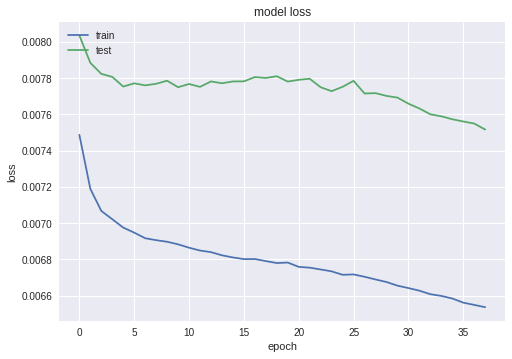

In [13]:
if history != None:
  # summarize history for accuracy
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

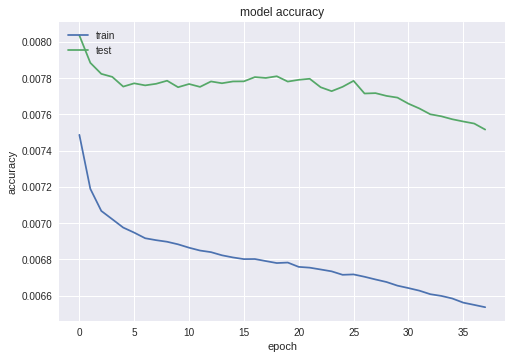

In [14]:
if history != None:
  # summarize history for accuracy
  plt.plot(history.history['binary_crossentropy'])
  plt.plot(history.history['val_binary_crossentropy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

## Make predictions

In [0]:
decoder = decodesyllables.Decoder(cmudict.CMUDict())
lm = languagemodel.SyllableModel()
lm.loadModel()


In [16]:
history = None
#new_text = np.array(new_text, dtype=object)[:, np.newaxis]
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model_transfer.h5')  
  predicts = model.predict(test_text_d, batch_size=32)


NameError: ignored

In [0]:
max_variants = 50
max_predicts = 50
num_tests = min(max_predicts, len(predicts[0]))
for i in range(num_symbols):
  predicts[i] = predicts[i][0:num_tests]


In [0]:
# Count # of probs > 0.5
sum = {5:0, 4:0, 3:0, 2:0, 1:0}
count = 0
for v in np.nditer(np.reshape(predicts, len(predicts)*len(predicts[0])*len(predicts[0][0]))):
    count += 1
    if v > 0.5:
        sum[5] += 1
    if v > 0.4:
        sum[4] += 1
    if v > 0.3:
        sum[3] += 1
    if v > 0.2:
        sum[2] += 1
    if v > 0.1:
        sum[1] += 1
print("{} out of {} active values".format(sum, count))

In [0]:
for j in range(num_tests):
  print("Predicting sentence: " + test_text[j])
  data = [[]] * num_symbols
  for i in range(num_symbols):
    data[i] = predicts[i][j]
  #beams = word_beam_search_decoder(data, max_variants, lm)
  beams = beam_search_decoder(data, max_variants, minProb=0.01)
  #print("Beam[0]: {}".format(beams[0]))
  beams.reverse()
  #print("Beams shape: {}".format(np.array(beams).shape))
  for k in range(0, 10):
    if k >= len(beams):
        break
    #    if k == 0:
    #        print("Score[{0}]: {1} ".format(k, beams[k][1]))
    #print("Indexes[{0}]: {1}".format(k, beams[k][0]))
    syll_set = [''] * num_symbols
    for i in range(num_symbols):
      syll_set[i] = syll_mgr.get_syllable(beams[k][0][i])
    #print("Syllables: {}".format(syll_set))
    count = 0
    for s in decoder.decode_sentence(syll_set):
      print(s)
      count += 1
      if count == 4:
        break
 

In [0]:
junk don't run

In [0]:

os.remove('./model_transfer.h5')